# Problem #1

In this problem, we will build a Multilayer Perceptron (MLP) and train it on the MNIST hand- written digit dataset 1.
Building the Model Consider an MLP with two hidden layers where the number of hidden units as $h^1$ and $h^2$. For the MNIST dataset, the number of features of the input data $h^0$ is 784. The output of the neural network is parameterized by a softmax of $h^3 = 10$ classes.

1. Build an MLP and choose the values of $h^1$ and $h^2$ such that the total number of parameters (including biases) falls within the range of $[0.5M, 1.0M]$.
2. Train the MLP using the probability loss (*cross entropy*) as training criterion. We minimize this criterion to optimize the model parameters using *stochastic gradient descent*.

In the following sub-questions, please specify the model architecture (number of hidden units per layer, and the total number of parameters), the nonlinearity chosen as neuron activation, learning rate, mini-batch size.

**Initialization** In this sub-question, we consider different initial values for the weight parameters. Set the biases to be zeros, and consider the following settings for the weight parameters:

* Zero: all weight parameters are initialized to be zeros (like biases).
* Normal: sample the initial weight values from a standard Normal distribution: $w_{i,j} ∼ \mathcal{N}(w_{i,j}; 0,1)$
* Glorot: sample the initial weight values from a uniform distribution; $w_{i, j}^l ∼ \mathcal{U}(w_{i, j}^l ; −d^l, d^l)$ where $d^l = \sqrt{\frac{6}{h^{l−1} +h^l}}$

1. Train the model for 10 epochs 2 using the initialization methods above and record the average loss measured on the training data at the end of each epoch (10 values for each setup).
2. Compare the three setups by plotting the losses against the training time (epoch) and comment on the result.

**Learning Curves** From now on, use the Glorot initialization method. In this subquestion and
the next one, we consider different scenarios and model assumptions to explore the concept of
generalization.

1. Find out a combination of hyper-parameters (model architecture, learning rate, nonlinearity, etc.) such that the average accuracy rate on the validation set $(r^{(valid)})$ is at least 97%.
2. Plot a figure of learning curves with the x-axis being the training time and the y-axis being the accuracy. The plot should include the accuracy measured on both training and validation sets at the end of each epoch.
3. Train the model for 100 epochs.
4. Train the model for 100 epochs, this time double model capacity (in terms of number of parameters).
5. Comment on the result. (Hint: explain it using the bias-variance trade-off.)

**Training Set Size, Generalization Gap, and Standard Error.** Choose the best model and training specification you have designed so far in terms of validation accuracy.
1. Randomly draw subsets of the training data with $N_a = aN$ samples, where $N = 50000$ is the number of samples of the full training set of MNIST, for $a \in \{0.01, 0.02, 0.05, 0.1, 1.0\}$. For each subset, train a model for 100 epochs.
  
  a. Keep track of accuracy measured on the i. training set, ii. validation set, iii. test set at the end of each epoch
  
  b. Report the generalization gap defined as the difference between the training accuracy and the test accuracy $(G_a = r^{(train)} − r^{(test)})$ of the model with best validation performance
  
  c. Repeat this procedure 3 times and you should end up with a Table of size 5 × 5 (5 trials
and 5 training set sizes).
2. Repeat this procedure 3 times and you should end up with a Table of size 5 × 5 (5 trials and
5 training set sizes).
3. Report the average generalization gap for each subset size and its corresponding standard
error. Recall that the standard error of a statistic is the standard deviation of its sampling
distribution.
4. Comment on the result.

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

# Question 1.1

MLP(
  (hidden_1): Linear(in_features=784, out_features=512)
  (hidden_2): Linear(in_features=512, out_features=400)
  (output): Linear(in_features=400, out_features=10)
)
batch size:40  learning rate:0.01  momentum:0.8 
epoch = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch = 0
epoch = 0
[19.825438   1.3139706]
[nan nan]
[157.73668 163.15129]


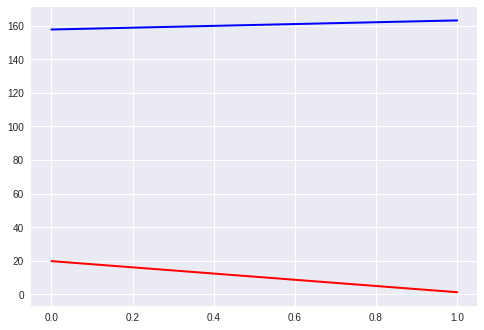

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle
from enum import Enum, auto

import torch
import torch.nn.functional as F
from torch.autograd import Variable

np.random.seed(0)


class Init(Enum):
    Glorot = auto()
    Normal = auto()
    Zero = auto()


# MLP model
class MLP(torch.nn.Module):
    """build the MLP network model"""

    def __init__(self, n_feature, n_hidden_1, n_hidden_2, n_output):
        super(MLP, self).__init__()
        self.hidden_1 = torch.nn.Linear(n_feature, n_hidden_1)
        self.hidden_2 = torch.nn.Linear(n_hidden_1, n_hidden_2)
        self.output = torch.nn.Linear(n_hidden_2, n_output)

    def forward(self, x):
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = F.log_softmax(x)
        x = self.output(x)
        return x


def get_balanced_batches(dataset_length, shuffle, batch_size: int = 50):
    """Create indices for batches balanced that allows to
       split the dataset into balanced batches (maximum size difference 1),
       shuffle the indices if needed.
    """
    assert batch_size is not None
    n_batches = int(np.round(dataset_length / float(batch_size)))

    min_batch_size = dataset_length // n_batches
    n_batches_with_extra_trial = dataset_length % n_batches
    assert n_batches_with_extra_trial < n_batches
    all_inds = np.array(range(dataset_length))
    if shuffle:
        np.random.shuffle(all_inds)
    i_start_trial = 0
    i_stop_trial = 0
    batches = []
    for i_batch in range(n_batches):
        i_stop_trial += min_batch_size
        if i_batch < n_batches_with_extra_trial:
            i_stop_trial += 1
        batch_inds = all_inds[range(i_start_trial, i_stop_trial)]
        batches.append(batch_inds)
        i_start_trial = i_stop_trial
    assert i_start_trial == dataset_length
    return batches


def train_mlp(mlp, train_data, train_labels, test_data, init: Init = Init.Glorot,
              batch_size: int = 100, epoches: int = 100, learning_rate=0.5, momentum=0.1):
    """train the dataset folliowing the  """
    train_num = len(train_data)
    if torch.cuda.is_available():
        mlp = mlp.cuda()

    # init bias
    torch.nn.init.constant(mlp.hidden_1.bias, 0)
    torch.nn.init.constant(mlp.hidden_2.bias, 0)
    torch.nn.init.constant(mlp.output.bias, 0)

    # init weight to zero
    if init == Init.Zero:

        torch.nn.init.constant(mlp.hidden_1.weight, 0)
        torch.nn.init.constant(mlp.hidden_2.weight, 0)
        torch.nn.init.constant(mlp.output.weight, 0)
    # init weight to normal
    elif init == Init.Normal:

        torch.nn.init.normal(mlp.hidden_1.weight, mean=0, std=1)
        torch.nn.init.normal(mlp.hidden_2.weight, mean=0, std=1)
        torch.nn.init.normal(mlp.output.weight, mean=0, std=1)
    # init weight to Glorot
    else:
        torch.nn.init.xavier_uniform(mlp.hidden_1.weight, gain=1)
        torch.nn.init.xavier_uniform(mlp.hidden_2.weight, gain=1)
        torch.nn.init.xavier_uniform(mlp.output.weight, gain=1)

    optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate, momentum=momentum)
    loss_func = torch.nn.CrossEntropyLoss()
    losses = torch.zeros(epoches, 3)
    losses = Variable(losses)

    for epoch in range(epoches):
        mlp.train()
        if epoch % 10 == 0:
          print('epoch = %d' % epoch)
        shuffle = True
        batches_indexes = get_balanced_batches(train_num, shuffle, batch_size)

        for i_batch, example_inds in enumerate(batches_indexes):
            inputs = torch.from_numpy(train_data[example_inds])
            labels = torch.from_numpy(train_labels[example_inds])
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)
            # forward propagation
            prediction = mlp(inputs)
            loss = loss_func(prediction, labels)

            losses[epoch, 0] = losses[epoch, 0] + loss.data[0]
            # train the model by backpropation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # average_loss of each epoch
        losses[epoch, 1] = losses[epoch, 0] / (train_num / batch_size)
        losses[epoch, 2] = epoch
    return losses


# hyper parameter
batch_size = 40
learning_rate = 0.01
momentum = 0.8
epoches = 2

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

X, y = (mnist.data.astype(np.float32) / 255), mnist.target
permutation = np.random.permutation(len(X))
X = X[permutation]
y = y[permutation]
train_set = (X[:50000], y[:50000].astype(np.int64))
val_set = (X[50000:60000], y[50000:60000].astype(np.int64))
test_set = (X[60000:], y[60000:].astype(np.int64))

train_data = train_set[0].reshape(-1, 28 * 28)
train_labels = train_set[1]

test_data = test_set[0].reshape(-1, 28 * 28)
test_labels = test_set[1]

validation_data = val_set[0].reshape(-1, 28 * 28)
validation_labels = val_set[1]

# set the structure of network
mlp = MLP(28 * 28, 512, 400, 10)
print(mlp)
print("batch size:{0}  learning rate:{1}  momentum:{2} ".format(batch_size, learning_rate, momentum))

# train the model by three initialization strategies and get the loss
list_losses = []
for init in Init:
    losses1 = train_mlp(mlp, train_data, train_labels, test_data, init,
                        batch_size, epoches, learning_rate, momentum)
    list_losses.append(losses1)

# plot the losses
# Glorot
plt.plot(list_losses[0].data.numpy()[:, 2], list_losses[0].data.numpy()[:, 1], 'r', lw=2, label="Glorot")
print(list_losses[0].data.numpy()[:, 1])
# Normal
plt.plot(list_losses[1].data.numpy()[:, 2], list_losses[1].data.numpy()[:, 1], 'g', lw=2, label="Normal")
print(list_losses[1].data.numpy()[:, 1])
#
plt.plot(list_losses[2].data.numpy()[:, 2], list_losses[2].data.numpy()[:, 1], 'b', lw=2, label="Zeros")
print(list_losses[2].data.numpy()[:, 1])
plt.show()

As can been seen above, Glorot initialization appears to train most quickly, leading to the lowest loss under a fixed number of training epochs.

# Question 1.2

MLP(
  (hidden_1): Linear(in_features=784, out_features=512)
  (hidden_2): Linear(in_features=512, out_features=400)
  (output): Linear(in_features=400, out_features=10)
)
batch size:40  learning rate:0.01  momentum:0.8 
epoch = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[0.75736    0.9264     0.94666    0.95892    0.96318    0.97112
 0.97562003 0.97662    0.97958    0.98212004]
[0.9081     0.9249     0.94740003 0.9378     0.9628     0.95
 0.9688     0.96930003 0.9599     0.9699    ]


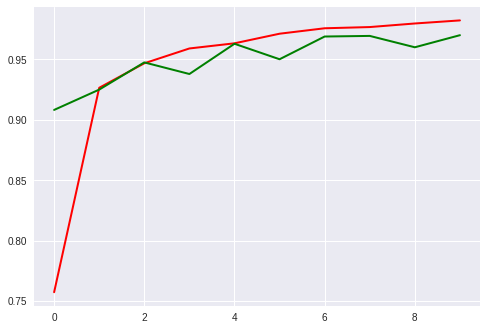

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle
from enum import Enum, auto

import torch
import torch.nn.functional as F
from torch.autograd import Variable

class Init(Enum):
    Glorot = auto()
    Normal = auto()
    Zero = auto()

# MLP
class MLP(torch.nn.Module):
    def __init__(self, n_feature, n_hidden_1, n_hidden_2, n_output):
        super(MLP, self).__init__()
        self.hidden_1 = torch.nn.Linear(n_feature, n_hidden_1)
        self.hidden_2 = torch.nn.Linear(n_hidden_1, n_hidden_2)
        self.output = torch.nn.Linear(n_hidden_2, n_output)

    def forward(self, x):
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = F.log_softmax(x)
        x = self.output(x)
        return x

def get_balanced_batches(dataset_length, shuffle, batch_size: int = 50):
    """Create indices for batches balanced in size (batches will have maximum size difference of 1).
    Supply either batch size or number of batches. Resulting batches
    will not have the given batch size but rather the next largest batch size
    that allows to split the set into balanced batches (maximum size difference 1).
    Parameters
    ----------
    dataset_length : int
        Size of set. 
    shuffle :
        Whether to shuffle indices before splitting set.
    batch_size :
         (Default value = None)
    Returns
    -------
    """
    assert batch_size is not None
    n_batches = int(np.round(dataset_length / float(batch_size)))

    min_batch_size = dataset_length // n_batches
    n_batches_with_extra_trial = dataset_length % n_batches
    assert n_batches_with_extra_trial < n_batches
    all_inds = np.array(range(dataset_length))
    if shuffle:
        np.random.shuffle(all_inds)
    i_start_trial = 0
    i_stop_trial = 0
    batches = []
    for i_batch in range(n_batches):
        i_stop_trial += min_batch_size
        if i_batch < n_batches_with_extra_trial:
            i_stop_trial += 1
        batch_inds = all_inds[range(i_start_trial, i_stop_trial)]
        batches.append(batch_inds)
        i_start_trial = i_stop_trial
    assert i_start_trial == dataset_length
    return batches

def train_mlp(mlp, train_data, train_labels, test_data, test_labels, init: Init = Init.Glorot,
              batch_size: int = 100, epoches: int = 100, learning_rate=0.5, momentum=0.1):
    train_num = len(train_data)
    test_num = len(test_data)

    if torch.cuda.is_available():
        mlp = mlp.cuda()

    # init bias
    torch.nn.init.constant(mlp.hidden_1.bias, 0)
    torch.nn.init.constant(mlp.hidden_2.bias, 0)
    torch.nn.init.constant(mlp.output.bias, 0)

    # init weight to zero
    if init == Init.Zero:

        torch.nn.init.constant(mlp.hidden_1.weight, 0)
        torch.nn.init.constant(mlp.hidden_2.weight, 0)
        torch.nn.init.constant(mlp.output.weight, 0)
    # init weight to normal
    elif init == Init.Normal:

        torch.nn.init.normal(mlp.hidden_1.weight, mean=0, std=1)
        torch.nn.init.normal(mlp.hidden_2.weight, mean=0, std=1)
        torch.nn.init.normal(mlp.output.weight, mean=0, std=1)
    # init weight to Glorot
    else:

        torch.nn.init.xavier_uniform(mlp.hidden_1.weight, gain=1)
        torch.nn.init.xavier_uniform(mlp.hidden_2.weight, gain=1)
        torch.nn.init.xavier_uniform(mlp.output.weight, gain=1)

    optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate, momentum=momentum)
    loss_func = torch.nn.CrossEntropyLoss()

    accuracy = torch.zeros(epoches, 3)
    accuracy = Variable(accuracy)

    for epoch in range(epoches):
        mlp.train()
        if epoch % 10 == 0:
          print('epoch = %d' % epoch)
        shuffle = True
        batches_indexes = get_balanced_batches(train_num, shuffle, batch_size)
        train_accuarcy_list = []

        for i_batch, example_inds in enumerate(batches_indexes):

            inputs = torch.from_numpy(train_data[example_inds])
            labels = torch.from_numpy(train_labels[example_inds])
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)

            # forward
            prediction = mlp(inputs)
            loss = loss_func(prediction, labels)

            train_accuarcy_list.append(AccuarcyCompute(prediction, labels))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # accuracy rate on training set of each epoch
        accuracy[epoch, 0] = (sum(train_accuarcy_list) / len(train_accuarcy_list))

        shuffle = False
        batches_indexes = get_balanced_batches(test_num, shuffle, batch_size)
        test_accuarcy_list = []
        for i_batch, example_inds in enumerate(batches_indexes):
            inputs = torch.from_numpy(test_data[example_inds])
            labels = torch.from_numpy(test_labels[example_inds])
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)

            prediction = mlp(inputs)
            test_accuarcy_list.append(AccuarcyCompute(prediction, labels))
        # accuracy rate on testset of each epoch
        accuracy[epoch, 1] = (sum(test_accuarcy_list) / len(test_accuarcy_list))
        accuracy[epoch, 2] = epoch
    return accuracy


def AccuarcyCompute(pred, label):
    pred = pred.cpu().data.numpy()
    label = label.cpu().data.numpy()
    #     print(pred.shape(),label.shape())
    test_np = (np.argmax(pred, 1) == label)
    test_np = np.float32(test_np)
    return np.mean(test_np)


# loading local dataset
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

X, y = (mnist.data.astype(np.float32) / 255), mnist.target
permutation = np.random.permutation(len(X))
X = X[permutation]
y = y[permutation]
train_set = (X[:50000], y[:50000].astype(np.int64))
val_set = (X[50000:60000], y[50000:60000].astype(np.int64))
test_set = (X[60000:], y[60000:].astype(np.int64))

train_data = train_set[0].reshape(-1, 28 * 28)
train_labels = train_set[1]

test_data = test_set[0].reshape(-1, 28 * 28)
test_labels = test_set[1]

validation_data = val_set[0].reshape(-1, 28 * 28)
validation_labels = val_set[1]

# hyper parameter
batch_size = 40
learning_rate = 0.01
momentum = 0.8
epoches = 10  # for the question 3/4, replacement this value by 100
init = Init.Glorot

# set the structure of network
mlp = MLP(28 * 28, 512, 400, 10)
print(mlp)
print("batch size:{0}  learning rate:{1}  momentum:{2} ".format(batch_size, learning_rate, momentum))
# train the model and evaluate the accuracy with the validation set
accuracy = train_mlp(mlp, train_data, train_labels, validation_data, validation_labels, init,
                     batch_size, epoches, learning_rate, momentum)

# plot the accuracy rate for both training set and validation set
plt.plot(accuracy.data.numpy()[:, 2], accuracy.data.numpy()[:, 0], 'r', lw=2, label="training accuracy")
print(accuracy.data.numpy()[:, 0])
plt.plot(accuracy.data.numpy()[:, 2], accuracy.data.numpy()[:, 1], 'g', lw=2, label="test accuracy")
print(accuracy.data.numpy()[:, 1])
plt.show()

# Question 1.3

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle
from enum import Enum, auto

import torch
import torch.nn.functional as F
from torch.autograd import Variable


class Init(Enum):
    Glorot = auto()
    Normal = auto()
    Zero = auto()


# MLP
class MLP(torch.nn.Module):

    def __init__(self, n_feature, n_hidden_1, n_hidden_2, n_output):
        super(MLP, self).__init__()
        self.hidden_1 = torch.nn.Linear(n_feature, n_hidden_1)
        self.hidden_2 = torch.nn.Linear(n_hidden_1, n_hidden_2)
        self.output = torch.nn.Linear(n_hidden_2, n_output)

    def forward(self, x):
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = F.log_softmax(x)
        x = self.output(x)
        return x


def get_balanced_batches(dataset_length, shuffle, batch_size: int = 50):
    """Create indices for batches balanced in size (batches will have maximum size difference of 1).
    Supply either batch size or number of batches. Resulting batches
    will not have the given batch size but rather the next largest batch size
    that allows to split the set into balanced batches (maximum size difference 1).
    Parameters
    ----------
    dataset_length : int
        Size of set. 
    shuffle :
        Whether to shuffle indices before splitting set.
    batch_size :
         (Default value = None)
    Returns
    -------
    """
    assert batch_size is not None
    n_batches = int(np.round(dataset_length / float(batch_size)))

    min_batch_size = dataset_length // n_batches
    n_batches_with_extra_trial = dataset_length % n_batches
    assert n_batches_with_extra_trial < n_batches
    all_inds = np.array(range(dataset_length))
    if shuffle:
        np.random.shuffle(all_inds)
    i_start_trial = 0
    i_stop_trial = 0
    batches = []
    for i_batch in range(n_batches):
        i_stop_trial += min_batch_size
        if i_batch < n_batches_with_extra_trial:
            i_stop_trial += 1
        batch_inds = all_inds[range(i_start_trial, i_stop_trial)]
        batches.append(batch_inds)
        i_start_trial = i_stop_trial
    assert i_start_trial == dataset_length
    return batches


def train_mlp(mlp, train_data, train_labels, validation_data, validation_labels, test_data, test_labels,
              init: Init = Init.Glorot,
              batch_size: int = 100, epoches: int = 100, learning_rate=0.5, momentum=0.1):
    train_num = len(train_data)
    test_num = len(test_data)
    validation_num = len(validation_data)

    if torch.cuda.is_available():
        mlp = mlp.cuda()

    # init bias
    torch.nn.init.constant(mlp.hidden_1.bias, 0)
    torch.nn.init.constant(mlp.hidden_2.bias, 0)
    torch.nn.init.constant(mlp.output.bias, 0)

    # init weight to zero
    if init == Init.Zero:
        torch.nn.init.constant(mlp.hidden_1.weight, 0)
        torch.nn.init.constant(mlp.hidden_2.weight, 0)
        torch.nn.init.constant(mlp.output.weight, 0)
    # init weight to normal
    elif init == Init.Normal:
        torch.nn.init.normal(mlp.hidden_1.weight, mean=0, std=1)
        torch.nn.init.normal(mlp.hidden_2.weight, mean=0, std=1)
        torch.nn.init.normal(mlp.output.weight, mean=0, std=1)
    # init weight to Glorot
    else:
        torch.nn.init.xavier_uniform(mlp.hidden_1.weight, gain=1)
        torch.nn.init.xavier_uniform(mlp.hidden_2.weight, gain=1)
        torch.nn.init.xavier_uniform(mlp.output.weight, gain=1)

    optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate, momentum=momentum)
    loss_func = torch.nn.CrossEntropyLoss()
    losses = torch.zeros(epoches, 3)
    losses = Variable(losses)

    accuracy = torch.zeros(epoches, 5)
    accuracy = Variable(accuracy)

    for epoch in range(epoches):
        if epoch % 10 == 0:
          print('epoch = %d' % epoch)
        shuffle = True
        batches_indexes = get_balanced_batches(train_num, shuffle, batch_size)
        train_accuarcy_list = []

        for i_batch, example_inds in enumerate(batches_indexes):

            inputs = torch.from_numpy(train_data[example_inds])
            labels = torch.from_numpy(train_labels[example_inds])
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)

            # forward
            prediction = mlp(inputs)
            loss = loss_func(prediction, labels)
            losses[epoch, 0] = losses[epoch, 0] + loss.data[0]

            train_accuarcy_list.append(AccuarcyCompute(prediction, labels))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # average_loss of each epoch
        losses[epoch, 1] = losses[epoch, 0] / (train_num / batch_size)
        losses[epoch, 2] = epoch
        # accuracy rate on training set of each epoch
        accuracy[epoch, 1] = (sum(train_accuarcy_list) / len(train_accuarcy_list))

        # print 10 loss values
        # if  (10*i)%(train_num /batch_size)== 0:
        #    print('current loss = %.5f' % loss.data[0])

        shuffle = False
        batches_indexes = get_balanced_batches(test_num, shuffle, batch_size)
        test_accuarcy_list = []
        for i_batch, example_inds in enumerate(batches_indexes):
            inputs = torch.from_numpy(test_data[example_inds])
            labels = torch.from_numpy(test_labels[example_inds])
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)

            prediction = mlp(inputs)
            test_accuarcy_list.append(AccuarcyCompute(prediction, labels))
        # accuracy rate on testset of each epoch
        accuracy[epoch, 3] = (sum(test_accuarcy_list) / len(test_accuarcy_list))

        shuffle = False
        batches_indexes = get_balanced_batches(validation_num, shuffle, batch_size)
        validation_accuarcy_list = []
        for i_batch, example_inds in enumerate(batches_indexes):
            inputs = torch.from_numpy(validation_data[example_inds])
            labels = torch.from_numpy(validation_labels[example_inds])
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)

            prediction = mlp(inputs)
            validation_accuarcy_list.append(AccuarcyCompute(prediction, labels))
        # accuracy rate on testset of each epoch
        accuracy[epoch, 2] = (sum(validation_accuarcy_list) / len(validation_accuarcy_list))
        accuracy[epoch, 4] = accuracy[epoch, 1] - accuracy[epoch, 3]
        accuracy[epoch, 0] = epoch

    return accuracy


def AccuarcyCompute(pred, label):
    pred = pred.cpu().data.numpy()
    label = label.cpu().data.numpy()
    #     print(pred.shape(),label.shape())
    test_np = (np.argmax(pred, 1) == label)
    test_np = np.float32(test_np)
    return np.mean(test_np)


def sample_dataset(dataset, alpha):
    sample_index = np.random.choice(len(dataset[0]), int(alpha * len(dataset[0])))
    new_dataset = (dataset[0][sample_index], dataset[1][sample_index])
    return new_dataset


def training_one_trial(mlp, train_set, alpha):
    train_set = sample_dataset(train_set, alpha)

    train_data = train_set[0].reshape(-1, 28 * 28)
    train_labels = train_set[1]

    test_data = test_set[0].reshape(-1, 28 * 28)
    test_labels = test_set[1]

    validation_data = val_set[0].reshape(-1, 28 * 28)
    validation_labels = val_set[1]

    # hyper parameter
    batch_size = 40
    learning_rate = 0.01
    momemtum = 0.8
    epoches = 100
    init = Init.Glorot

    accuracy = train_mlp(mlp, train_data, train_labels, validation_data, validation_labels,
                         test_data, test_labels, init,
                         batch_size, epoches, learning_rate, momemtum)
    return accuracy


def training_subsets_one_trial():
    list_accuracy = []
    for alpha in sample_alpha:
        accuracy = training_one_trial(mlp, train_set, alpha)
        list_accuracy.append(accuracy)
    return list_accuracy


def training_subsets_trials():
    list_accuracy_all_trials = []
    list_averaged_accuracy = []
    for alpha in sample_alpha:
        list_accuracy = []
        for i in range(5):
            accuracy = training_one_trial(mlp, train_set, alpha)
            list_accuracy.append(accuracy[-1, :])
        averaged_accuracy = (
                    sum(list_accuracy) / len(list_accuracy))  # averaged accuracy of all train,test,validation,gap
        list_accuracy_all_trials.append(list_accuracy)
        list_averaged_accuracy.append(averaged_accuracy)
    return list_accuracy_all_trials, list_averaged_accuracy


# loading local dataset
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

X, y = (mnist.data.astype(np.float32) / 255), mnist.target
permutation = np.random.permutation(len(X))
X = X[permutation]
y = y[permutation]
train_set = (X[:50000], y[:50000].astype(np.int64))
val_set = (X[50000:60000], y[50000:60000].astype(np.int64))
test_set = (X[60000:], y[60000:].astype(np.int64))

# set the structure of network
mlp = MLP(28 * 28, 512, 400, 10)
print(mlp)

sample_alpha = [0.01, 0.02, 0.05, 0.1, 1.0]

# question 1
list_accuracy = training_subsets_one_trial()

MLP(
  (hidden_1): Linear(in_features=784, out_features=512)
  (hidden_2): Linear(in_features=512, out_features=400)
  (output): Linear(in_features=400, out_features=10)
)
epoch = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40


# Question 1.a

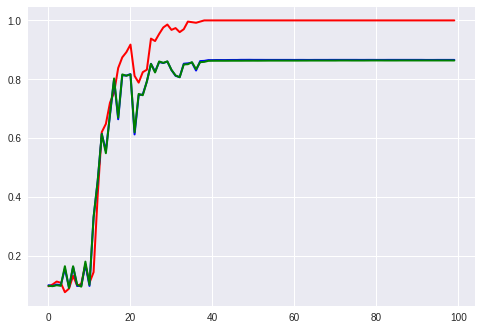

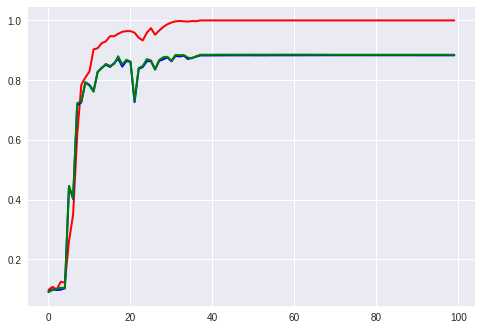

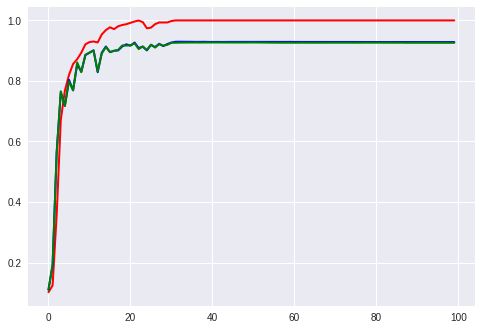

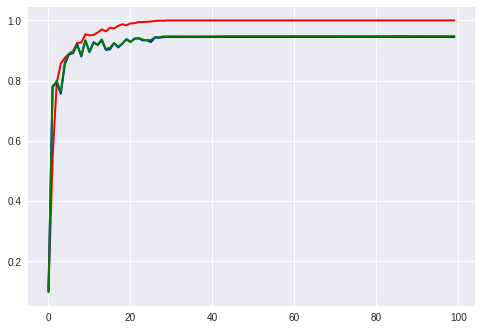

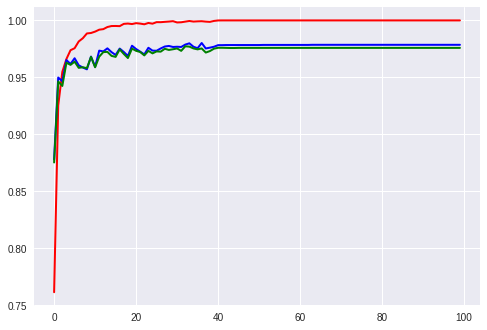

In [13]:
i = 1
for accuracy in list_accuracy:
    plt.figure(i)
    i += 1
    plt.plot(accuracy.data.numpy()[:, 0], accuracy.data.numpy()[:, 1], 'r', lw=2, label="training set accuracy")
    plt.plot(accuracy.data.numpy()[:, 0], accuracy.data.numpy()[:, 2], 'b', lw=2, label="validation set accuracy")
    plt.plot(accuracy.data.numpy()[:, 0], accuracy.data.numpy()[:, 3], 'g', lw=2, label="test set accuracy")
plt.show()

# Generalization Gap


In [14]:
for alpha, accuracy in zip(sample_alpha, list_accuracy):
    print("alpha: {0}  generalization gap: {1}".format(alpha, accuracy.data.numpy()[-1, 4]))

alpha: 0.01  generalization gap: 0.13630002737045288
alpha: 0.02  generalization gap: 0.11500000953674316
alpha: 0.05  generalization gap: 0.07400000095367432
alpha: 0.1  generalization gap: 0.05210000276565552
alpha: 1.0  generalization gap: 0.024100005626678467


The model with the lowest generalization gap has an alpha of 1.0. 

# Problem 1.c

In [0]:
# question 2 and 3
list_accuracy_all_trials, list_averaged_accuracy = training_subsets_trials()

epoch = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 

In [0]:
# question 2
for list_accuracy in list_accuracy_all_trials:
    print("alpha:{0},  trials:{1},  training accuracy:{2},  validation accuracy:{3},"
          "  test accuracy:{4},  generalization gap: {5}".format(alpha, i, accuracy.data.numpy()[-1, 1],
                                                                 accuracy.data.numpy()[-1, 2],
                                                                 accuracy.data.numpy()[-1, 3],
                                                                 accuracy.data.numpy()[-1, 4]))

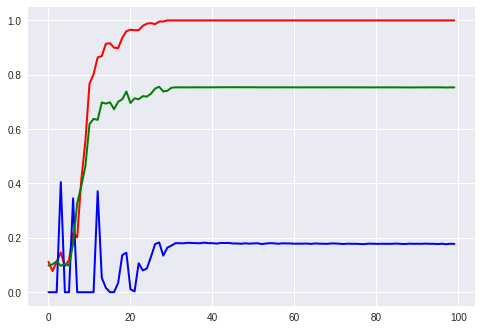

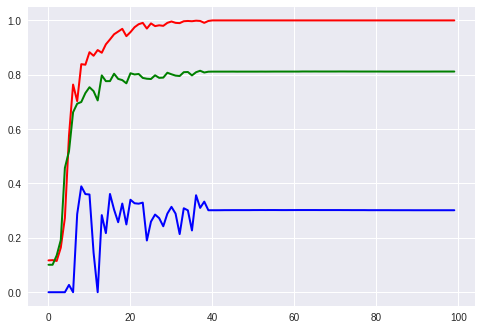

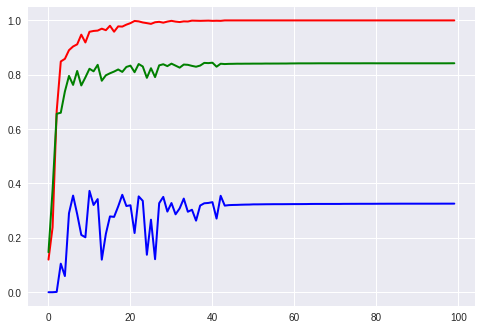

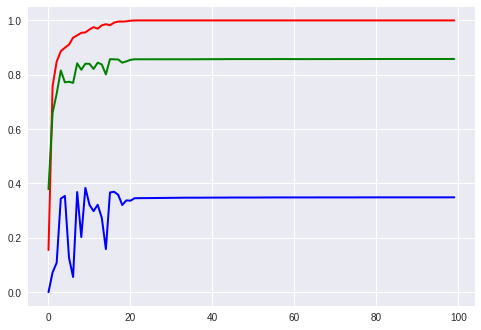

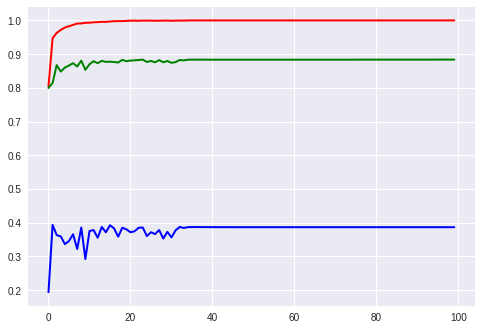

alpha: 0.01  generalization gap: 0.24650001525878906
alpha: 0.02  generalization gap: 0.18809998035430908
alpha: 0.05  generalization gap: 0.15759998559951782
alpha: 0.1  generalization gap: 0.14190000295639038
alpha: 1.0  generalization gap: 0.11619997024536133
epoch = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0
epoch = 10
epoch = 20
epoch = 30
epoch = 40
epoch = 50
epoch = 60
epoch = 70
epoch = 80
epoch = 90
epoch = 0


In [0]:
# question 3
for alpha, averaged_accuracy in zip(sample_alpha, list_averaged_accuracy):
    print("alpha: {0}  generalization gap: {1}".format(alpha, averaged_accuracy.data.numpy()[-1, 4]))

# Problem #2

In this problem, we will build a Multi-layer Perceptron (MLP) and train it on the 20 Newsgroups. 20 Newsgroups is a collection of roughly 20,000 documents taken from 20 different newsgroups (comp.graphics, sci.electronics, etc). The task is to predict which group the document comes from. Process the data as follows:

1. Each document is represented as a bag of words. Each document $x_i$ is represented as a vector the size of the vocabulary (around 50k in our case). Each position $x_{ij}$ is then the count of how many times the word $w_j$ appears in document $x_i$.

## Building the model 

For the following question, use an MLP with a single hidden layer of size 100, initialized using the Glorot initialization. A momentum 6 of 0.9 should also be used during the training. We will look at the effect that preprocessing can have on the results. Consider the three following preprocessing procedures:

* **No preprocessing**: The input of the model is the count of the different words.
* **tf-idf**: All the words in the documents are processed according to their tf-idf( Standard way to preprocess text document data). You can implement your own version of tf-idf if you prefer, but feel free to use the implementation from here. The focus is the importance of preprocessing.
* **Standardization**: All word counts in the document in the training and test set are normalized so that the mean is 0 and variance is 1: $d_i^j=\frac{d_i^j-u_{j_{train}}}{\sigma j_{train}+\epsilon}$, where $\epsilon=1e-5$.

For the three processing procedures do a quick hyper-parameter search for the learning rate. Plot
the accuracy on the training and test set for 20 epochs.

1. Briefly discuss the results,
2. and answer the following points in a few lines each:

  a. Could the same learning rate could be used for all of the models? Why, or why not?
  
  b. What might have happened if  = 0 for the Standardization preprocessing? Why? Besides modifying, how else could we deal with this problem?
  
  c. What advantage does tf-idf has over basic word count approach that could help the model learn better?
  
##Variance in training

Using the same MLP as the previous question and the tf-idf preprocessing, do the following: Using **only** vanilla SGD, and a minibatch size of 1, record the loss on the training set for the first 5000 updates (not epoch!). Do the same thing with a minibatch size of 100 and plot them. The same learning rate should be used in both settings. It should also be high enough that the loss is clearly going down (≥ 0.1 is a good starting point).

Answer the following questions:

* Given that the two models had updates of the same magnitude, how do you explain the variance and the difference in the loss?

*  If we could only have a minibatch of size 1, what technique could we use to reduce the variance during training? Explain the intuition behind it.

In [0]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
import matplotlib.pyplot as plt

from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch


class newsDataset(Dataset):

    def __init__(self, train_data, target_data, transform=None):
        self.train_data = train_data
        self.target_data = target_data
        self.transform = transform
        if transform == 'stdize':
            self.feat_means = np.mean(train_data.toarray(), axis=0)
            self.feat_stds = np.std(train_data.toarray(), axis=0)

    def __len__(self):
        return self.train_data.shape[0]

    def get_data_length(self):
        return self.train_data.shape[1]

    def __getitem__(self, idx):
        if self.transform == 'stdize':
            return (
                np.array((self.train_data[idx]-self.feat_means)/(1e-5+self.feat_stds)).reshape(-1),
                self.target_data[idx])
        else:
            return (self.train_data[idx].toarray(), self.target_data[idx])


def load_data(transformation, batch_size):
    #  Load data
    newsgroups_data = fetch_20newsgroups(data_home='./', subset='all')
    newsgroups_targets = newsgroups_data.target

    count_vect = CountVectorizer(min_df=10)
    newsgroups_input_data = count_vect.fit_transform(newsgroups_data.data)
    del newsgroups_data, count_vect

    if transformation == 'tfidf':
        tfidf_transformer = TfidfTransformer()
        newsgroups_input_data = tfidf_transformer.fit_transform(newsgroups_input_data)
        print('applied tfidf successfully!')
    #if transformation == 'stdize':
    #    feat_means = np.mean(newsgroups_input_data.toarray(), axis=0)
    #    newsgroups_input_data -= feat_means
    #    del feat_means
    #    feat_vars = np.std(newsgroups_input_data.toarray(), axis=0)
    #    newsgroups_input_data /= (feat_vars + 1e-5)
    #    del feat_vars
    #    print('standardized columns successfully!')

    train_ind = int(newsgroups_targets.shape[0]*0.6)
    valid_ind = int(newsgroups_targets.shape[0]*0.8)

    training_data = newsDataset(train_data=newsgroups_input_data[0:train_ind],
                                target_data=newsgroups_targets[0:train_ind],
                                transform=transformation)
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=8)

    input_size, output_size = training_data.get_data_length(), 20

    del training_data

    valid_data = newsDataset(train_data=newsgroups_input_data[(train_ind+1):valid_ind],
                             target_data=newsgroups_targets[(train_ind+1):valid_ind],
                             transform=transformation)
    valid_dataloader = DataLoader(valid_data, batch_size=64, shuffle=True, num_workers=8)

    del valid_data, train_ind

    test_data = newsDataset(train_data=newsgroups_input_data[(valid_ind+1):],
                            target_data=newsgroups_targets[(valid_ind+1):],
                            transform=transformation)

    del newsgroups_targets, newsgroups_input_data, valid_ind

    test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=8)

    del test_data

    return train_dataloader, valid_dataloader, test_dataloader, input_size, output_size


#  Build the model
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        a = np.sqrt(6 / (100 + input_size))
        torch.nn.init.uniform(self.fc1.weight, -a, a)

        self.fc2 = nn.Linear(100, output_size)
        a = np.sqrt(6 / (100 + output_size))
        torch.nn.init.uniform(self.fc2.weight, -a, a)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)


def compute_accuracy(model, dataloader, input_size):
    error = 0
    acc = 0
    total = 0

    for i_batch, (data, target) in enumerate(dataloader):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data.float()), Variable(target)
        data = data.view(-1, input_size)

        pred = model(data)
        loss = F.nll_loss(pred, target)
        error += loss.data[0]

        acc += (torch.max(pred, 1)[1].eq(target)).sum().data[0]
        total += len(target)

    return 100 * (acc / total), error / len(dataloader)


def train_model(model, lr, epochs, compute_test_error, train_dataloader,
                valid_dataloader, test_dataloader,
                input_size, transformation, momentum, get_updates=False):

    train_accuracy = []
    valid_accuracy = []
    test_accuracy = []
    if get_updates:
        updates = []

    # create a stochastic gradient descent optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    for epoch in range(epochs):
        train_acc = 0
        total = 0
        model.train()
        end = False

        for i_batch, (data, target) in enumerate(train_dataloader):
            data, target = data.cuda(), target.cuda()
            data, target = Variable(data.float()), Variable(target)
            data = data.view(-1, input_size)
            optimizer.zero_grad()

            pred = model(data)
            loss = F.nll_loss(pred, target)

            if get_updates:
                updates.append(loss.data[0])
                if len(updates) > 5000:
                    return updates

            if loss.data[0] > 10000:
                print('learning is too unstable, terminating ...')
                end = True
                break

            loss.backward()
            optimizer.step()

            if i_batch % 25 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i_batch, len(train_dataloader),
                           100. * i_batch / len(train_dataloader), loss.data[0]))

            train_acc += (torch.max(pred, 1)[1].eq(target)).sum().data[0]
            total += len(target)

        if end:
            train_accuracy.append(0)
            valid_accuracy.append(0)
            test_accuracy.append(0)
            break

        train_accuracy.append(100*(train_acc/total))

        model.eval()
        acc, error = compute_accuracy(model, valid_dataloader, input_size)
        print('Valid Epoch: {} Loss: {:.6f} Accuracy: {:.6f} %'.format(epoch, error, acc))
        valid_accuracy.append(acc)

        if compute_test_error:
            acc, error = compute_accuracy(model, test_dataloader, input_size)
            test_accuracy.append(acc)

    if compute_test_error:
        plt.figure()
        plt.title('Accuracy of Training and Test Sets for Transformation: {}'.format(transformation))
        plt.plot(train_accuracy, color='red', label='Training Set')
        plt.plot(test_accuracy, color='blue', label='Test Set')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper right')
        plt.savefig('Accuracy-{}'.format(transformation))
        plt.axis([0, epochs, 0, 100])
        plt.show()

    return train_accuracy, valid_accuracy, test_accuracy


def find_best_hyperparam(epochs, transformation, batch_size):
    train_dataloader, valid_dataloader, test_dataloader, input_size, output_size = load_data(transformation, batch_size)

    #  Hyperparam Search
    best_hyperparam = 0.00001
    best_acc = 0
    for hyperparam in [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]:
        model = Net(input_size=input_size, output_size=output_size)
        model.cuda()
        _, valid_accuracy, _ = \
        train_model(model=model, lr=hyperparam, epochs=epochs, compute_test_error=False,
                    train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,
                    test_dataloader=test_dataloader, input_size=input_size,
                    transformation=transformation, momentum=0.9)
        valid_acc = valid_accuracy[-1]
        print('learning rate {} has accuracy: {:.6f}'.format(hyperparam, valid_acc))
        if valid_acc > best_acc:
            best_acc = valid_acc
            best_hyperparam = hyperparam
            print('New best hyperparam: {:.6f}'.format(best_hyperparam))

    model = Net(input_size=input_size, output_size=output_size)
    model.cuda()
    train_accuracy, valid_accuracy, test_accuracy = \
        train_model(model=model, lr=best_hyperparam, epochs=epochs, compute_test_error=True,
                    train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,
                    test_dataloader=test_dataloader,
                    input_size=input_size, transformation=transformation, momentum=0.9)
    return best_hyperparam, train_accuracy, valid_accuracy, test_accuracy

# Q 2.1
final_outcome = list()
for trans in ['stdize', 'tfidf', 'no transformation']:

    best_hyperparam, train_accuracy, valid_accuracy, test_accuracy = \
        find_best_hyperparam(epochs=20, transformation=trans, batch_size=64)

    final_outcome.append([trans, best_hyperparam, train_accuracy[-1], test_accuracy[-1]])

    print('\n####################################################\n')
    print('Best hyperparameter for transformation {}: {}\n'.format(trans, best_hyperparam))
    print('#####################################################\n')

print(final_outcome)

train_dataloader, valid_dataloader, test_dataloader, input_size, output_size = load_data('tfidf', batch_size=1)
model = Net(input_size=input_size, output_size=output_size)
model.cuda()
updates_1 = train_model(model=model, lr=0.1, epochs=1, compute_test_error=False,
            train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,
            test_dataloader=test_dataloader,
            input_size=input_size, transformation='tfidf', momentum=0, get_updates=True)
del train_dataloader, valid_dataloader, test_dataloader, input_size, output_size

train_dataloader, valid_dataloader, test_dataloader, input_size, output_size = load_data('tfidf', batch_size=100)
updates_2 = train_model(model=model, lr=0.1, epochs=100, compute_test_error=False,
            train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,
            test_dataloader=test_dataloader,
            input_size=input_size, transformation='tfidf', momentum=0, get_updates=True)

plt.figure()
plt.title('Per Update Loss with Different Minibatch Sizes')
plt.plot(updates_1, color='red', label='Minibatch size 1')
plt.plot(updates_2, color='blue', label='Minibatch size 100')
plt.xlabel('Update')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('loss-minibatch')
plt.axis([0, 5000, 0, 5])
plt.show()

# Answers

## Q2.1

| Data Set          | Best Learning Rate | Training Accuracy | Test Accuracy |
|-------------------|:------------------:|:-----------------:|:-------------:|
| stdize            | 0.01               | 99.902            | 86.707        |
| tfidf             | 0.05               | 99.770            | 90.103        |
| no transformation | 0.005              | 98.399            | 82.409        |

1.) Without transformations, and with large learning rates, the model would overfit before the 20th epoch, so learning rate had to be small. With standardization, the training was unstable for learning rates >0.01, and otherwise the model performed comparably to the model trained on the original data. With the tfidf, the model performed well across learning rates >0.005 (otherwise, the learning would take much longer than 20 epochs). Therefore, they all worked well with a learning rate of 0.01, but each performed optimally at different rates.

2.) If $\epsilon = 0$ for the Standardization preprocessing, we may have had numerical issues coming from very small standard deviations. This could occur with very common words or very rare words. One way to deal with the problem is to exclude the most common and rare words from the model.

3.) tf-idf has the advantage of adding weight to words which do no appear often and removing weight from common words. Words which only appear in a few document often have high predictive power, and words that are very common often do not.

## Q2.2

1.) The variance is higher with minibatches of size 1, since larger minibatches is essentially just averaging over the gradients of the minibatch (since variance of average is $\frac{1}{n}$ the variance of the single example by the CLT)

2.) If we had to have a minibatch of size 1, we could decrease the learning rate so that the optimization is less sensitive to any perturbations from the higher variance.